# Description

There are some really important question for me and other young people who are going to work in 'data sphere' 
1. How much will I earn
2. What are my chances of finding a job
3. What professions are hidden under the pretentious name 'Data Science' (there isn't strict classification)
4. What should I know to be employed

And here you can look through thr whole process of researching starting with data mining using api and finishing with the presentation of the results

Also you can watch results in interactive format in that [dashboard](https://public.tableau.com/app/profile/george.raz/viz/VacanciesAnalizing/VacanciesAnalize?publish=yes)

# Importing libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import os
from IPython.display import HTML
import random
import warnings
import json
pd.options.mode.chained_assignment = None
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
# Function that hides particular cells 
def hide_toggle(for_next=False, toggle_text="Toggle show/hide"):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

#     toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle(toggle_text="Hide function")

# Parcing data using the hh.ru api

The hidenn cell below contains defining of the class that parses hh.ru using it's api

In [4]:
class HHRUParser:
    def __init__(self, api_url='https://api.hh.ru/vacancies', exp_variants=None, area="113", per_page="20", page=0):
        if exp_variants is None:
            exp_variants = ["noExperience", "between1And3"]
        self.api_url = api_url
        self.exp_variants = exp_variants
        self.area = area
        self.per_page = per_page
        self.page = page
        # self.req_params = {"area": area, 'per_page': per_page, 'page': page, "experience": exp_variants}

    def parse_page(self, page_number, job):
        """
        The function that takes information about particular vacancies
        (selected by params mentioned in init function) and if response was got
        it would return the response in json format
        :param page_number: int, the number of page with vacancies
        :param job: str, the name of job you searching for
        :return: json file or None if status code of response isn't equivalent to 200
        """
        req_params = {'text': job, "area": self.area, 'per_page': self.per_page, 'page': page_number, "experience": self.exp_variants}
        response = requests.get(self.api_url, params=req_params)
        if response.status_code == 200:
            json_result = response.json()["items"]
            return json_result
        return None

    def parse_job(self, job, start_page=0, limit_amount=49, save=False, res_dir=None, res_extension=None):
        """
        The function that searches information about particular job looking through limit_amount pages
        which contains information about that job
        :param job: str, the name of job you searching for
        :param limit_amount: int, the maximum amount of pages which will be parsed
        :param save: bool, if True result will be saved in mentioned format
        :param res_dir: str, the directory where result will be saved if 'save' parameter set to True
        default - current directory
        :param res_extension: str, (if 'save' parameter set to True) if 'csv' result will be saved in csv format 
        if 'json' result will be saved in json format. I \n other cases result will be saved in csv format
        :return: pd.DataFrame, DataFrame that contains information about all vacancies that were parsed 
        """
        if start_page + 49 < limit_amount:
            warnings.warn("The limit amount is too large if you need to get more pages \
                          it's necessary to call that function multiple times.")
        job_result = []
        for page_number in range(start_page, max(start_page + 49, limit_amount)):
            page_result = self.parse_page(page_number=page_number, job=job)
            if page_result:
                job_result.extend(page_result)
        job_result = pd.DataFrame(job_result)

        if save:
            if res_dir is None:
                res_dir = os.getcwd()
            if res_extension is None:
                res_extension = "csv"
            res_file = f"{res_dir}\\{'_'.join(job.split())}.{res_extension}"

            if res_extension == "csv":
                job_result.to_csv(res_file, index=False)
            if res_extension == "json":
                job_result.to_json(res_file)
            else:
                print("Mentioned unexisting extension. File will be saved as cssv file.")
                job_result.to_csv(res_file, index=False)

        return job_result
    
hide_toggle(toggle_text="HHRUParser")

In [7]:
parser_params = {"api_url":  'https://api.hh.ru/vacancies', "area": "113", 
                 'per_page':'50', 'page':0, "exp_variants": ["noExperience", "between1And3"]}
parser = HHRUParser(**parser_params)

In [9]:
data_analyst_vacs = parser.parse_job("Data Analyst", limit_amount=49)

In [10]:
data_scientist_vacs = parser.parse_job("Data Scientist", limit_amount=49)

In [11]:
ml_vacs = parser.parse_job("Machine Learning", limit_amount=49)

In [12]:
data_analyst_rus_vacs = parser.parse_job("аналитик данных", limit_amount=49)

In [48]:
vacs_copy = data_analyst_vacs.copy()

# Preposessing data

The hidenn cell below contains defining of the class that transforms information taht was get from hh.ru by extracting important features and deleting useless ones.

In [5]:
class VacanciesPreprocessor:
    def __init__(self):
        # words we will look for in list of requirements
        self.potential_required_skills = ['python', 'sql', 'scikit', 'pandas', 'numpy', 'seaborn', 'matplotlib', 'pytorch',
                   'mysql', 'beautifulsoup', 'selenium', 'ml algorithms', 'statistic', 'анализ данных',
                   'tableau', 'git', 'html', 'javascript', 'css', 'linux', 'php', 'ооп', 'jquery',
                   'postgresql', 'java', 'html5', 'css3', 'английский', 'язык', 'управление', 'проектами',
                   'c#', 'c++', 'ajax', 'sql', 'docker', 'powerbi', 'a/b', 'google analytics', 'статистика',
                   'прецентации', 'fastapi', 'pytest', 'sqlalchemy', 'gitlab', 'transformers', 'spark',
                   'airflow', 'keras', 'hadoop', 'scala', 'excel', 'r', 'go',
                   'google spreadsheets', 'ml ', 'excel', 'hive', 'tensorflow', 'высшее техническое',
                   'высшее математическое', 'теория вероятности', 'nkp', 'nltk', 'cv2']
        # keywords which should be included in job name
        self.valid_profession_names = ["data", "analyst", "scientist", "machine", "learning",
                          "ml", " ai", " nlp", "разработчик", "python", "scien",
                          "computer", "vision", "обучени", "анали", "программи", "analytic"]
        # keywords which should be excluded from job name
        self.exclude_words = ["middle+", "senior", "engineer", "инженер"]

    def fit(self):
        """
        Function don't do anything.
        Created only to match the sclearn interface.
        :return: None
        """
        pass

    def is_profession_name_valid(self, name):
        """
        The functions that check if name of job contains at least one of valid names
        and doesn't contain any of invalid words
        :param name: str, name of job
        :return: bool, True if job name is valid
        """
        contains_valid_words = any([valid_name in name.lower() for valid_name in self.valid_profession_names])
        if contains_valid_words:
            return not any([exclude_word in name.lower() for exclude_word in self.exclude_words])
        else:
            return False

    def drop_invalid_vacancies(self, vacancies):
        """
        Function that checks all the job names and drops vacancies which have invalid job names
        :param vacancies: pd.DataFrame, dataFrame that contains information about vacancies
        :return: pd.DataFrame, dataFrame that contains only valid vacancies
        """
        vacancies["valid_profession"] = vacancies["name"].apply(lambda name: self.is_profession_name_valid(name))
        vacancies["valid_role"] = vacancies["professional_roles"].apply(lambda role: self.is_profession_name_valid(role))
        invalid_idx = vacancies[(vacancies['valid_profession'] == False) | (vacancies['valid_role'] == False)].index
        vacancies = vacancies.drop(index=invalid_idx, columns=["valid_profession", "valid_role"])
        return vacancies

    def normalize_salary(self, vacancies):
        """
        
        :param vacancies: 
        :return: 
        """
        
        def convert_salary(salary):
            if salary and not pd.isnull(salary):
                if "EUR" in salary:
                    return float(salary.replace("EUR", "")) * 90.16
                elif "USD" in salary:
                    return float(salary.replace("USD", "")) * 81.5
                elif "RUR" in salary:
                    return float(salary.replace("RUR", ""))
                
        vacancies["salary.to"] = vacancies["salary.to"].astype(str) + vacancies["salary.currency"].astype(str)
        vacancies["salary.from"] = vacancies["salary.from"].astype(str) + vacancies["salary.currency"].astype(str)
        vacancies["salary.to"] = vacancies["salary.to"].apply(lambda salary: convert_salary(
            salary))  # .replace({"RUR": "*1", "EUR": "*90.16", "USD": "*81.5"}, regex=True).map(pd.eval)
        vacancies["salary.from"] = vacancies["salary.from"].apply(lambda salary: convert_salary(
            salary))  # .replace({"RUR": "*1", "EUR": "*90.16", "USD": "*81.5"}, regex=True).map(pd.eval)
        vacancies = vacancies.rename(columns={"salary.to": "max_salary", "salary.from": "min_salary"}).drop(
            columns=["salary.currency"])
        return vacancies

    def scills_from_requirment(self, requirement):
        if requirement is None:
            return ""
        required_scills = ""
        requirement = requirement.lower()
        for scill in self.potential_required_skills:
            if scill in requirement and scill not in required_scills:
                required_scills += f"{scill} "
        return required_scills

    def extract_required_scills(self, vacancies):
        vacancies["snippet.requirement"] = vacancies["snippet.requirement"].apply(self.scills_from_requirment)
        return vacancies.rename(columns={"snippet.requirement": "required_scills"})

    def transform(self, vacancies):
        """
        The function that extracts required and delete unnecessary information
         about every vacancy from hh.ru api response
        :param vacancies: pd.DataFrame, dataframe which contains api response
        :return: pd.DataFrame, refactored dataframe after important features
        were extracted and useless features were dropped.
        """
        # The first step is to drop columns which contains useless information
        columns_to_drop = ["insider_interview", "department", "contacts",
                           "address", "apply_alternate_url", "url",
                           "sort_point_distance", "response_url",
                           "relations", "adv_response_url",
                           "working_days", "working_time_intervals",
                           "working_time_modes", "schedule"]
        vacancies = vacancies.drop(columns=columns_to_drop)
        # After that normalizing all the json data
        vacancies = vacancies.to_json(orient='records')
        vacancies = pd.json_normalize(json.loads(vacancies))
        # Extracting speciality_name
        vacancies["professional_roles"] = vacancies.professional_roles.apply(
            lambda role: role[0]["name"] if role and not pd.isnull(role) else role)
        # After roles were extracted we need to drop invalid vacancies which do not belong to our sphere
        vacancies = self.drop_invalid_vacancies(vacancies)
        # Extracting information about salary
        vacancies = self.normalize_salary(vacancies)
        # Extracting information about required skills
        vacancies = self.extract_required_scills(vacancies)
        # Deleting unnecessary columns
        columns_to_rename = {"area.name": "city", "type.id": "vacancy_relevance", "employer.name": "employer_name",
                             "experience.id": "required_experience", "employment.id": "employment_format"}

        columns_to_drop = ["area.id", "area.url", "type.name", "employer.id", "employer.url",
                           'employer.alternate_url', 'employer.logo_urls.original',
                           'employer.logo_urls.240', 'employer.logo_urls.90',
                           'employer.vacancies_url', 'employer.trusted', 'snippet.responsibility', 'experience.name',
                           'employment.name', 'salary.gross', 'employer.logo_urls', "salary"]

        vacancies = vacancies.drop(columns=columns_to_drop).rename(columns=columns_to_rename)

        # Converting columns which contains information about dates int datetime format
        vacancies["created_at"] = pd.to_datetime(vacancies["created_at"])
        vacancies["published_at"] = pd.to_datetime(vacancies["published_at"])
        return vacancies
    
    
hide_toggle(toggle_text="VacanciesPreprocessor")

In [84]:
preprocessor = VacanciesPreprocessor()

In [85]:
data_scientist_vacst = preprocessor.transform(data_scientist_vacs)

In [86]:
data_analyst_vacst = preprocessor.transform(data_analyst_vacs)

In [87]:
ml_vacst = preprocessor.transform(ml_vacs)

In [88]:
data_analyst_rus_vacst = preprocessor.transform(data_analyst_rus_vacs)

In [89]:
print(f"The data_scientist_vacst shape is: {data_scientist_vacst.shape}")
print(f"The data_analyst_vacst shape is: {data_analyst_vacst.shape}")
print(f"The ml_vacst shape is: {ml_vacst.shape}")
print(f"The data_analyst_rus_vacst shape is: {data_analyst_rus_vacst.shape}")

The data_scientist_vacst shape is: (82, 20)
The data_analyst_vacst shape is: (508, 20)
The ml_vacst shape is: (50, 20)
The data_analyst_rus_vacst shape is: (1687, 20)


In [90]:
# We want to get information about all the variants of vacancies 
# because there isn's strict classification about roles of workers with data
# so we need to concatenate all the vacancies in one data frame but mention the search words
data_scientist_vacst["search"] = "Data Scientist"
data_analyst_vacst["search"] = "Data Analyst"
ml_vacst["search"] = "Machine Learning"
data_analyst_rus_vacst["search"] = "аналитик данных"

In [136]:
vacancies = pd.concat([data_scientist_vacst, data_analyst_vacst,
                       ml_vacst, data_analyst_rus_vacst], axis=0, ignore_index=True)

In [137]:
# But we should delete duplicated vacancies which appeared in different search queries
vacancies = vacancies.drop_duplicates(subset="id", keep="first")

In [125]:
vacancies.shape

(2021, 21)

# Exploration analysis


## Salary

First and probably the most intriguing question is salary
a lot of vacancies haven't data about it, so it's necessary to ignore that vacancies

In [138]:
# Let's calculate the mean gap between max and min salary 
salaries = vacancies.loc[~(pd.isnull(vacancies["min_salary"])) & ~(pd.isnull(vacancies["max_salary"])), ("min_salary", "max_salary")]
salaries["max/min"] = salaries["max_salary"] / salaries["min_salary"]
max_min_sal_coef = np.mean(salaries["max/min"])
print(f"On average max salary greater than min salary in {round(max_min_sal_coef, 2)} times")
del salaries

On average max salary greater than min salary in 1.41 times


In [139]:
# Now we can calculate or interpolate mean salary for vacancies which contains information about at least one salary type
vacancies["mean_salary"] = np.nan
# Separating the sourse dataframe based on information about salaries
vacancies_both_salaries = vacancies.loc[~(pd.isnull(vacancies["min_salary"])) & ~(pd.isnull(vacancies["max_salary"]))]
vacancies_min_salary = vacancies.loc[~(pd.isnull(vacancies["min_salary"])) & (pd.isnull(vacancies["max_salary"]))]
vacancies_max_salary = vacancies.loc[(pd.isnull(vacancies["min_salary"])) & ~(pd.isnull(vacancies["max_salary"]))]
vacancies_no_salaries = vacancies.loc[(pd.isnull(vacancies["min_salary"])) & (pd.isnull(vacancies["max_salary"]))]

In [140]:
vacancies_no_salaries.shape

(1376, 22)

In [141]:
# Calculating the mean salary by special method for every particular part of sourse data frame
vacancies_both_salaries.loc[:,  "mean_salary"] = (vacancies_both_salaries["max_salary"] + vacancies_both_salaries["min_salary"]) / 2
vacancies_min_salary.loc[:, "mean_salary"] = vacancies_min_salary["min_salary"] * max_min_sal_coef
vacancies_max_salary.loc[:, "mean_salary"] = vacancies_max_salary["max_salary"] / max_min_sal_coef

In [142]:
# Concatenate it back
vacancies = pd.concat([vacancies_both_salaries, vacancies_min_salary, vacancies_max_salary, vacancies_no_salaries])
del vacancies_both_salaries, vacancies_min_salary, vacancies_max_salary, vacancies_no_salaries

In [131]:
print(f"The mean salary for data worker is: {round(vacancies['mean_salary'].mean(skipna=True), 0)} rub")
print("And it's only vacancies without required experience or with minimal experience")

The mean salary for data worker is: 97327.0 rub
And it's only vacancies without required experience or with minimal experience


Now let's look closely at difference between salaries for workers without experience and workers with minimal experience

As we can see the difference is seriously so it's more appropriately to try to respond to vacancies with requred experience


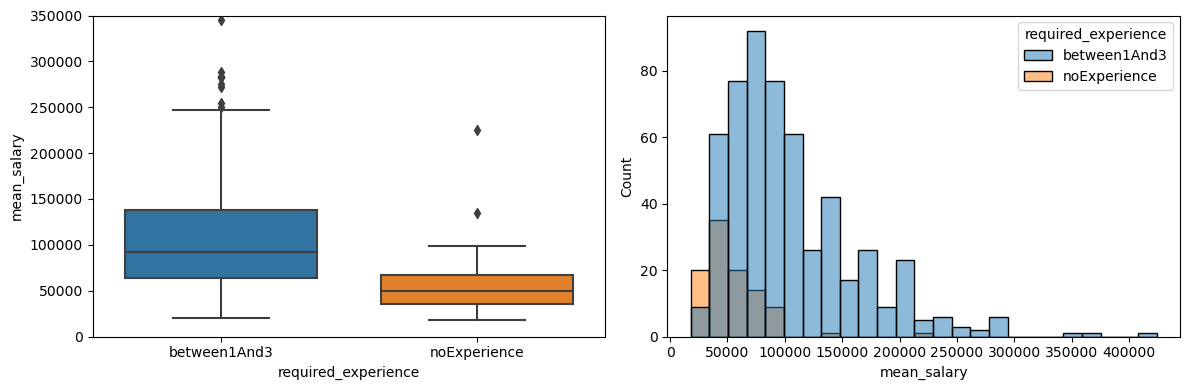

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=vacancies[~pd.isnull(vacancies["mean_salary"])], y="mean_salary", 
             x="required_experience", width=0.75, ax=axes[0])
axes[0].set_ylim([0, 350000])

sns.histplot(data=vacancies[~pd.isnull(vacancies["mean_salary"])], x="mean_salary", 
             hue="required_experience",  ax=axes[1])

plt.tight_layout()
print("As we can see the difference is seriously so it's more appropriately to try to respond to vacancies with requred experience")

hide_toggle(toggle_text="The distribution of salary between workers with different experience")

Now let's look at salary distribution in different cities

It's really surprizing results. We can conclude that there aren't any necessities to try to employ only in big city


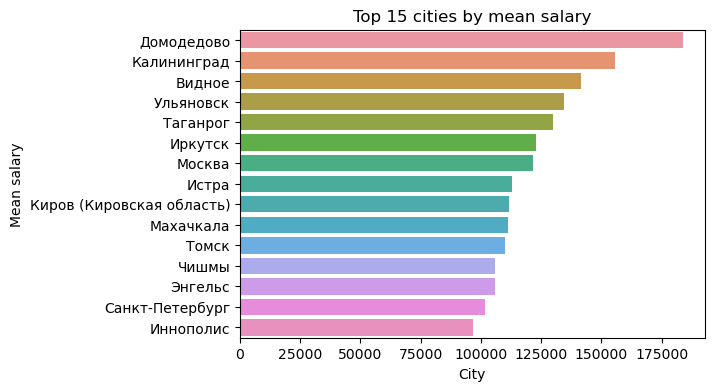

In [159]:
fig, axes = plt.subplots(figsize=(6, 4))
axes.set_title("Top 15 cities by mean salary")

sns.barplot(data=vacancies[~pd.isnull(vacancies["mean_salary"])].groupby("city").\
                                               aggregate({"mean_salary": "mean"}).\
                                               reset_index().\
                                               sort_values("mean_salary", ascending=False).head(15), 
            x="mean_salary", y="city", orient="h", ax=axes)
axes.set_xlabel("City")
axes.set_ylabel("Mean salary")
print("It's really surprizing results. We can conclude that there aren't any necessities to try to employ only in big city")

hide_toggle(toggle_text="Top 15 cities by mean salary")

Equally interesting question is what the distribution of salaries between different professional roles

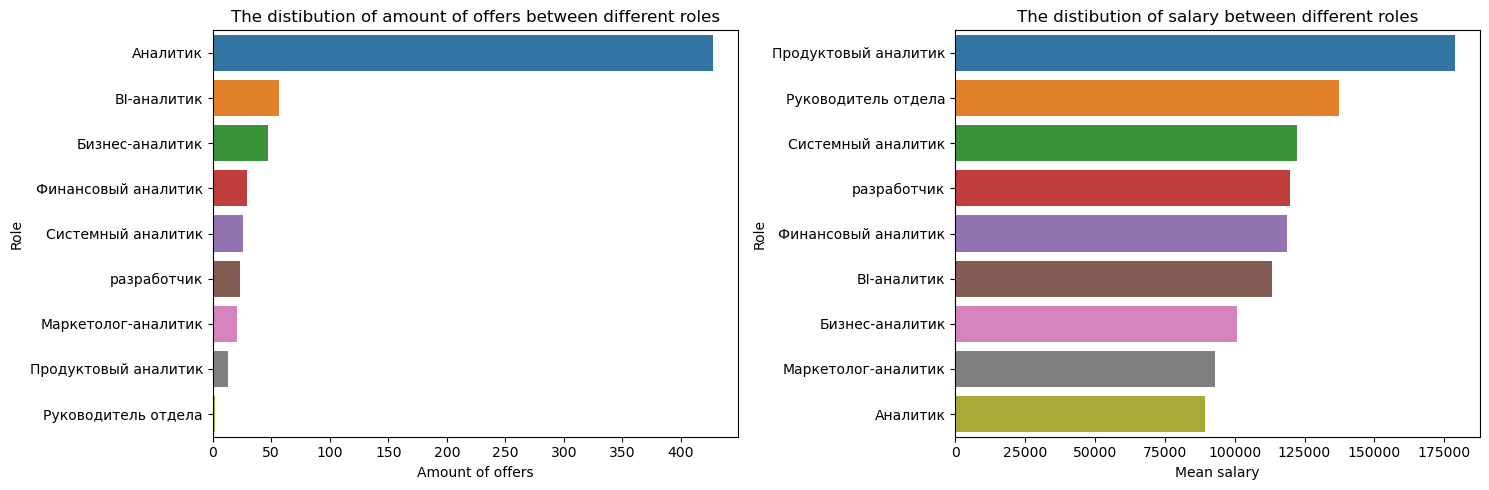

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title("The distibution of amount of offers between different roles")
sns.barplot(data=vacancies[~pd.isnull(vacancies["mean_salary"])].groupby("professional_roles").\
                                               aggregate({"id": "count"}).\
                                               reset_index().\
                                               sort_values("id", ascending=False), 
            x="id", y="professional_roles", orient="h", ax=axes[0])
axes[0].set_xlabel("Amount of offers")
axes[0].set_ylabel("Role")
axes[0].set_yticklabels(["Аналитик", "BI-аналитик", "Бизнес-аналитик", 
                         "Финансовый аналитик", "Системный аналитик", 
                         "разработчик", "Маркетолог-аналитик", 
                         "Продуктовый аналитик", "Руководитель отдела"])

axes[1].set_title("The distibution of salary between different roles")
sns.barplot(data=vacancies[~pd.isnull(vacancies["mean_salary"])].groupby("professional_roles").\
                                               aggregate({"mean_salary": "mean"}).\
                                               reset_index().\
                                               sort_values("mean_salary", ascending=False), 
            x="mean_salary", y="professional_roles", orient="h", ax=axes[1])
axes[1].set_ylabel("Role")
axes[1].set_xlabel("Mean salary")
axes[1].set_yticklabels(["Продуктовый аналитик", "Руководитель отдела",
                         "Системный аналитик", "разработчик",
                         "Финансовый аналитик", "BI-аналитик",
                         "Бизнес-аналитик", "Маркетолог-аналитик", 
                         "Аналитик"])
plt.tight_layout()
hide_toggle(toggle_text="Distibution between professional roles")

In [7]:
# It appears that not all of existing roles mentioned in vacancies
# So let's extract roles from vacansies names
pothential_roles = ["data", "analyst", "scientist", "machine", "learning", "BI", "Финансовый",
                    "Бизнес", "Системный", "Экономический", "Менеджер", "аналитик", "данных",
                    "Power", "Big Data", "машинн", "обуч", "System", "Business",
                    "SQL", "математик", "Google sheets", "Маркетинговый"
                    "ml", " ai", " nlp", "разработчик", "python", "scien",
                    "computer", "vision", "программи", "analytic", "продуктовый"]
pothential_roles = list(map(lambda word: word.lower(), pothential_roles))

def extract_roles_from_name(name):
    roles = []
    roles_replaces = {"аналитик": "analyst", "бизнес": "business", "продуктовый": "product",
                       "системный": "system", "данных": "data"}
    # order of searching key words is very important so it's necessary to use list
    roles_final_view = ["bi analyst", ["bi"], "business analyst", ["business"],
                        "system analyst", ["system"], "machine learning", ["machine", "learning"],
                        "data scientist", ["data", "scientist"], "менеджер", ["менеджер"],
                        "product analyst", ["product"],
                        "data analyst", ["data"],
                        "python developer", ["python"], "sql developer", ["sql"]]
    
    key_words = list(map(lambda word: word.lower(), name.split()))
    # Searching keywords in vacancy name 
    for role in pothential_roles:
        if role in name.lower():
            roles.append(role)
#     for key_word in key_words:
#         if key_word in pothential_roles:
#             roles.append(key_word)
    # Replacing all russian names
    roles = " ".join(set(sorted(roles)))
    for old_role, new_role in roles_replaces.items():
        roles = roles.replace(old_role, new_role)
    # Making the final view of role name
    for pair_idx in range(0, len(roles_final_view), 2):
        if all([(key_word in roles in roles) for key_word in roles_final_view[pair_idx+1]]):
            return roles_final_view[pair_idx]
    return "data analyst"


hide_toggle(toggle_text="extract roles from vacancy names")

In [14]:
# Adding roles which were extracted from name of vacancy
vacancies["name_roles"] = vacancies["name"].apply(extract_roles_from_name)

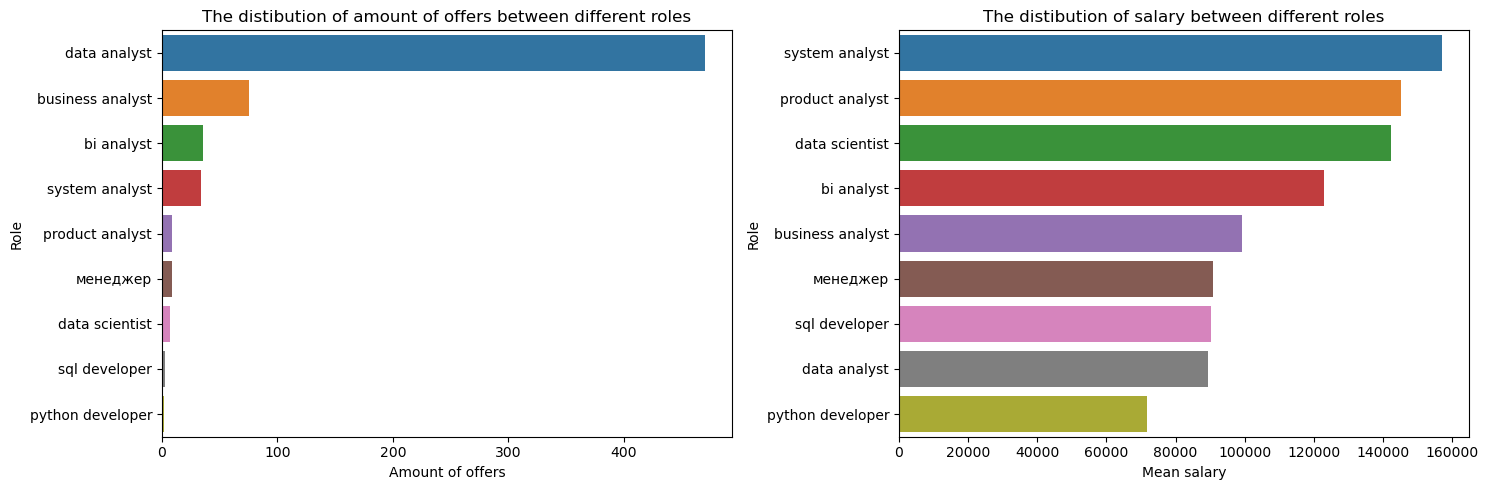

In [61]:
# And let's look at distribution betweeen that roles
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_title("The distibution of amount of offers between different roles")
sns.barplot(data=vacancies[~pd.isnull(vacancies["mean_salary"])].groupby("name_roles").\
                                               aggregate({"id": "count"}).\
                                               reset_index().\
                                               sort_values("id", ascending=False), 
            x="id", y="name_roles", orient="h", ax=axes[0])
axes[0].set_xlabel("Amount of offers")
axes[0].set_ylabel("Role")

axes[1].set_title("The distibution of salary between different roles")
sns.barplot(data=vacancies[~pd.isnull(vacancies["mean_salary"])].groupby("name_roles").\
                                               aggregate({"mean_salary": "mean"}).\
                                               reset_index().\
                                               sort_values("mean_salary", ascending=False), 
            x="mean_salary", y="name_roles", orient="h", ax=axes[1])
axes[1].set_ylabel("Role")
axes[1].set_xlabel("Mean salary")

plt.tight_layout()
hide_toggle(toggle_text="Distribution between name roles")

Let's take a view on most frequent employers and  employers who suggested the biggest salary

The absolute leader is 'СБЕР' all other top members is about 4-9 times less than it.


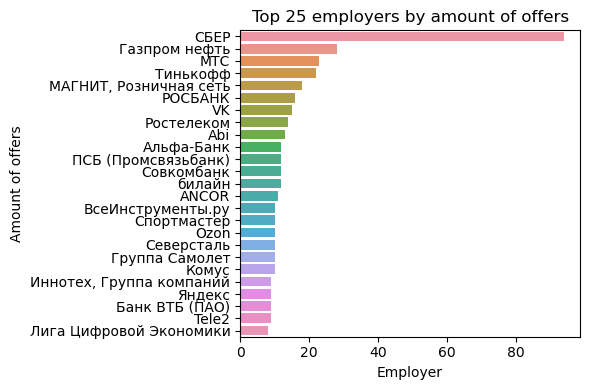

In [158]:
fig, axes = plt.subplots(figsize=(6, 4))
axes.set_title("Top 25 employers by amount of offers")

sns.barplot(data=vacancies.groupby("employer_name").\
                           aggregate({"id": "count"}).\
                           reset_index().rename(columns={"id": "offers_amount"}).\
                           sort_values("offers_amount", ascending=False).head(25), 
            x="offers_amount", y="employer_name", orient="h", ax=axes)
axes.set_xlabel("Employer")
axes.set_ylabel("Amount of offers")
plt.tight_layout()
print("The absolute leader is 'СБЕР' all other top members is about 4-9 times less than it.")

hide_toggle(toggle_text="Top 25 employers by amount of offers")

# Required scills

The next question is what's required from worker who will get salary like that

In [12]:
# First of all we need to concatenate names of some skills

pairs_to_concatenate = {"Scicit-Learn": ["scikit"],
                        "Scicit-Learn": ["learn"],
                        "анализ_данных": ["анализ", "данных"],
                        "английский_язык": ["английский"],
                        "управление_проектами": ["управление", "проектами"],
                        "google_analytics": ["google", "analytics"],
                        "google_spreadsheets": ["google", "spreadsheets"],
                        "высшее_техническое": ["высшее", "техническое"],
                        "высшее_математическое": ["высшее", "математическое"],
                        "теория_вероятности": ["теория", "вероятности"]}
words_to_delete = ["язык", "learn", "проектами"]

def concatenate_pairs(skills_string):
    for concat_seq, sequence in pairs_to_concatenate.items():
        if all([word in skills_string for word in sequence]):
            for word in sequence: 
                skills_string = skills_string.replace(f"{word}", " ")
            skills_string += concat_seq
    for word_to_del in words_to_delete:
        skills_string = skills_string.replace(f"{word_to_del} ", "")
    return skills_string

hide_toggle(toggle_text="Skill names pairs concatenating")            

In [15]:
# It's appropriate to create a separated dataframe with tokenized skills
vectorizer = CountVectorizer()
parsed_vectors = vectorizer.fit_transform(vacancies["required_scills"].apply(concatenate_pairs))
skill_names = vectorizer.get_feature_names_out()
required_skills = pd.DataFrame(data=parsed_vectors.toarray(), columns=skill_names)
required_skills = pd.concat([required_skills, vacancies.loc[:, ("id", "professional_roles", "name_roles")]], axis=1)

It's obviously that sql and pthon are necessary, but it's really surprizing that excel is so popular.


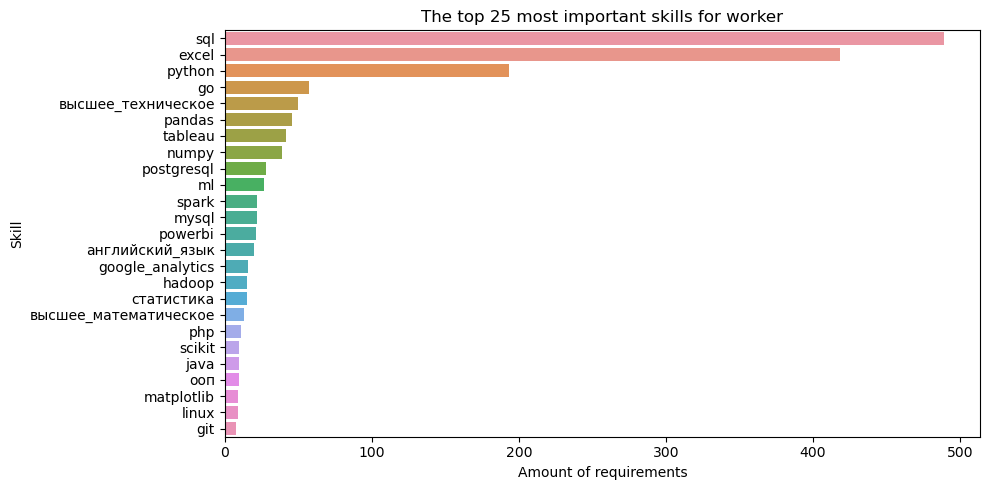

In [16]:
# Let's look at importance of particular skills for all types of workers
fig, axes = plt.subplots(figsize=(10, 5))
axes.set_title("The top 25 most important skills for worker")

sns.barplot(data=pd.DataFrame(required_skills.loc[:, skill_names].sum().sort_values(ascending=False), 
                              columns=["requires_amount"]).reset_index().head(25),  
            x="requires_amount", y="index", orient="h", ax=axes)
axes.set_xlabel("Amount of requirements")
axes.set_ylabel("Skill")
plt.tight_layout()
print("It's obviously that sql and pthon are necessary, but it's really surprizing that excel is so popular.")

hide_toggle(toggle_text="The top 25 most important skills for worker")    

In [9]:
# Now we can look clocely to every particular type  of worker
def select_skills_per_role(roles_column, required_skills, skill_names):
    prof_roles_scills = pd.DataFrame(data=skill_names, columns=["Skill"])
    for prof_role in vacancies[roles_column].unique():
        role_data = required_skills[(required_skills[roles_column]==prof_role)]
        offers_amount = role_data.shape[0]
        role_data = role_data.loc[:, skill_names].sum() / offers_amount * 100
        role_data = role_data.apply(lambda percent: round(percent, 2))
        prof_roles_scills[f"{prof_role}"] = role_data.values
    return prof_roles_scills

hide_toggle(toggle_text="Selecting statistic about skills per role")            

In [17]:
# Now let's count statistic obout skills per roles which was got from names
name_role_skills = select_skills_per_role("name_roles", required_skills, skill_names)
prof_role_skills = select_skills_per_role("professional_roles", required_skills, skill_names)

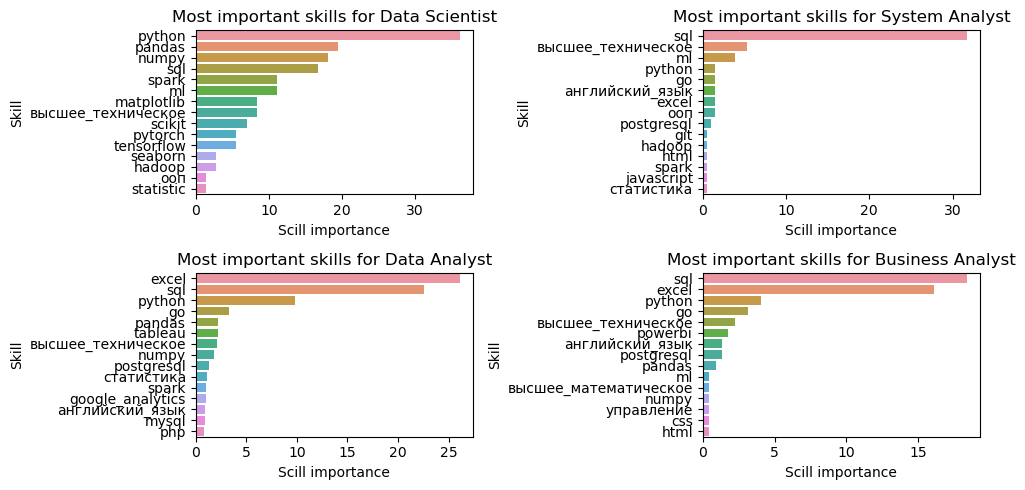

In [154]:
# Let's look at skills importance for some particular roles
# name_role_skills.loc[:, ("Skill", "")]
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0][0].set_title("Most important skills for Data Scientist")
sns.barplot(data=name_role_skills.loc[:, ("Skill", "data scientist")].\
                 sort_values("data scientist", ascending=False).head(15),  
            x="data scientist", y="Skill", orient="h", ax=axes[0][0])
axes[0][0].set_xlabel("Scill importance")

axes[1][0].set_title("Most important skills for Data Analyst")
sns.barplot(data=name_role_skills.loc[:, ("Skill", "data analyst")].\
                 sort_values("data analyst", ascending=False).head(15),  
            x="data analyst", y="Skill", orient="h", ax=axes[1][0])
axes[1][0].set_xlabel("Scill importance")

axes[0][1].set_title("Most important skills for System Analyst")
sns.barplot(data=name_role_skills.loc[:, ("Skill", "system analyst")].\
                 sort_values("system analyst", ascending=False).head(15),  
            x="system analyst", y="Skill", orient="h", ax=axes[0][1])
axes[0][1].set_xlabel("Scill importance")

axes[1][1].set_title("Most important skills for Business Analyst")
sns.barplot(data=name_role_skills.loc[:, ("Skill", "business analyst")].\
                 sort_values("business analyst", ascending=False).head(15),  
            x="business analyst", y="Skill", orient="h", ax=axes[1][1])
axes[1][1].set_xlabel("Scill importance")

plt.tight_layout()
hide_toggle(toggle_text="Most important skills for different roles")  

In [72]:
# Also we can look at different combinations of required scills
pair_vectorizer = CountVectorizer(ngram_range=(2, 2))
pair_parsed_vectors = pair_vectorizer.fit_transform(vacancies["required_scills"].apply(concatenate_pairs))
pair_names = pair_vectorizer.get_feature_names_out()
required_skills_pairs = pd.DataFrame(data=pair_parsed_vectors.toarray(), columns=pair_names)
required_skills_pairs = pd.concat([required_skills_pairs, vacancies["id"]], axis=1)

In [73]:
triple_vectorizer = CountVectorizer(ngram_range=(3, 3))
triple_parsed_vectors = triple_vectorizer.fit_transform(vacancies["required_scills"].apply(concatenate_pairs))
triple_names = triple_vectorizer.get_feature_names_out()
required_skills_triples = pd.DataFrame(data=triple_parsed_vectors.toarray(), columns=triple_names)
required_skills_triples = pd.concat([required_skills_triples, vacancies["id"]], axis=1)

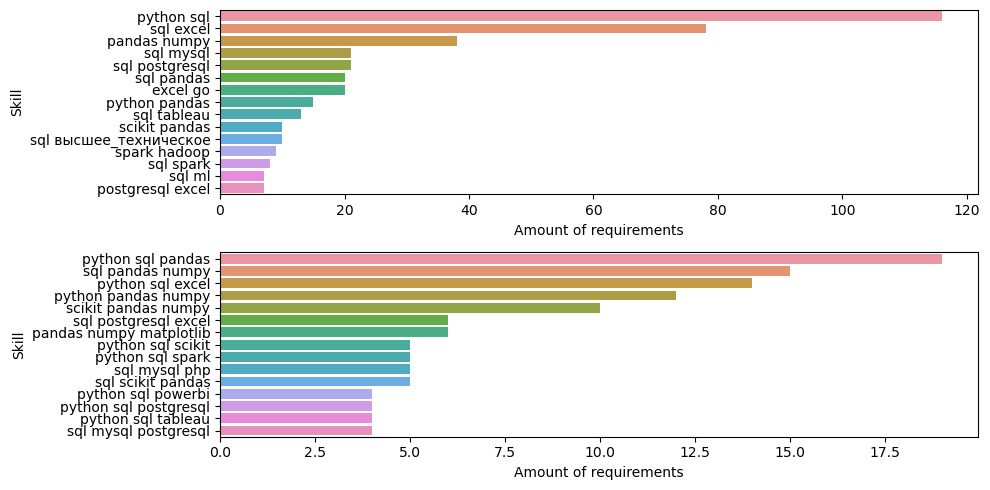

In [157]:
fig, axes = plt.subplots(2, 1,figsize=(10, 5))
# axes.set_title("The top 25 most importantscills for worker")

sns.barplot(data=pd.DataFrame(required_skills_pairs.loc[:, pair_names].sum().sort_values(ascending=False), 
                              columns=["requires_amount"]).reset_index().head(15),  
            x="requires_amount", y="index", orient="h", ax=axes[0])
axes[0].set_xlabel("Amount of requirements")
axes[0].set_ylabel("Skill")

sns.barplot(data=pd.DataFrame(required_skills_triples.loc[:, triple_names].sum().sort_values(ascending=False), 
                              columns=["requires_amount"]).reset_index().head(15),  
            x="requires_amount", y="index", orient="h", ax=axes[1])
axes[1].set_xlabel("Amount of requirements")
axes[1].set_ylabel("Skill")

plt.tight_layout()

hide_toggle(toggle_text="Most frequent combinations of required skills")  

## Meta information

In [46]:
vacancies["has_test"] = vacancies["has_test"].apply(lambda x: "Yes" if x else "No")
vacancies["response_letter_required"] = vacancies["response_letter_required"].apply(lambda x: "Yes" if x else "No")
meta_columns= ["has_test", "response_letter_required", "employment_format"]

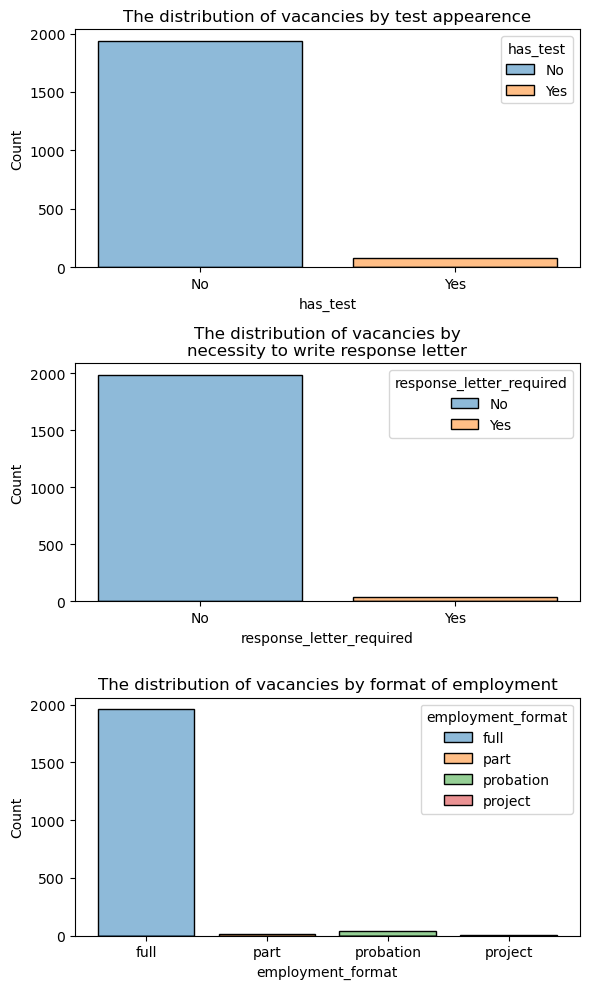

In [62]:
fig, axes = plt.subplots(3, 1,figsize=(6, 10))

sns.histplot(vacancies, x="has_test", ax=axes[0], shrink=.8, hue="has_test")
axes[0].set_title("The distribution of vacancies by test appearence")

sns.histplot(vacancies, x="response_letter_required", ax=axes[1], shrink=.8, hue="response_letter_required")
axes[1].set_title("The distribution of vacancies by\nnecessity to write response letter")

sns.histplot(vacancies, x="employment_format", ax=axes[2], shrink=.8, hue="employment_format")
axes[2].set_title("The distribution of vacancies by format of employment")

plt.tight_layout()
hide_toggle(toggle_text="vacancies Meta information")  